In [2]:
import scipy
# help(scipy)

In [3]:
from pathlib import Path
import numpy as np
from scipy.cluster.vq import whiten, kmeans, vq

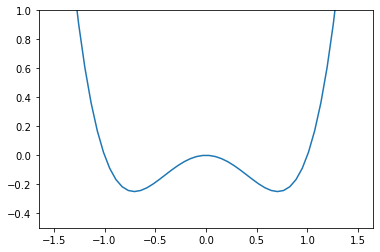

In [10]:
from matplotlib import pyplot as plt
import numpy as np

x = np.linspace(-1.5,1.5)
y = x**4 - x**2
fig, ax = plt.subplots()
plt.ylim(-0.5,1)
ax.plot(x, y);



You can see that you’re importing three functions from scipy.cluster.vq. Each of these functions accepts a NumPy array as input. These arrays should have the features of the dataset in the columns and the observations in the rows.



In [4]:
data = Path("data/SMSSpamCollection").read_text()
data = data.strip()
data = data.split("\n")

In [6]:
# data

You need to count the number of digits that appear in each text message. Python includes collections.Counter in the standard library to collect counts of objects in a dictionary-like structure. However, since all of the functions in scipy.cluster.vq expect NumPy arrays as input, you can’t use collections.Counter for this example. Instead, you use a NumPy array and implement the counts manually.

Again, you’re interested in the number of digits in a given SMS message, and how many SMS messages have that number of digits. First, you should create a NumPy array that associates the number of digits in a given message with the result of the message, whether it was ham or spam:

In [7]:
digit_counts = np.empty((len(data), 2), dtype=int)

The number of rows is equal to the number of messages in the dataset. You’ll be using digit_counts to associate the number of digits in the message with whether or not the message was spam.

You should create the array before entering the loop, so you don’t have to allocate new memory as your array expands.

In [8]:
for i, line in enumerate(data):
    case, message = line.split("\t")
    num_digits = sum(c.isdigit() for c in message)
    digit_counts[i, 0] = 0 if case == "ham" else 1
    digit_counts[i, 1] = num_digits

you want to apply the clustering algorithm to an array that has the number of messages with a certain number of digits. In other words, you need to create an array where the first column has the number of digits in a message, and the second column is the number of messages that have that number of digits.

In [9]:
unique_counts = np.unique(digit_counts[:, 1], return_counts=True)

In [10]:
unique_counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 40, 41, 47]),
 array([4110,  486,  160,   78,   42,   39,   16,   14,   28,   17,   16,
          34,   30,   31,   37,   29,   35,   33,   41,   47,   18,   31,
          28,   36,   34,   16,   16,   13,   19,    9,    2,    6,    3,
           4,    3,    4,    1,    1,    4,    2,    1]))

np.unique() takes an array as the first argument and returns another array with the unique elements from the argument.
Next, you need to transform unique_counts into a shape that’s suitable for clustering

In [11]:
unique_counts = np.transpose(np.vstack(unique_counts))

In [12]:
unique_counts

array([[   0, 4110],
       [   1,  486],
       [   2,  160],
       [   3,   78],
       [   4,   42],
       [   5,   39],
       [   6,   16],
       [   7,   14],
       [   8,   28],
       [   9,   17],
       [  10,   16],
       [  11,   34],
       [  12,   30],
       [  13,   31],
       [  14,   37],
       [  15,   29],
       [  16,   35],
       [  17,   33],
       [  18,   41],
       [  19,   47],
       [  20,   18],
       [  21,   31],
       [  22,   28],
       [  23,   36],
       [  24,   34],
       [  25,   16],
       [  26,   16],
       [  27,   13],
       [  28,   19],
       [  29,    9],
       [  30,    2],
       [  31,    6],
       [  32,    3],
       [  33,    4],
       [  34,    3],
       [  35,    4],
       [  36,    1],
       [  37,    1],
       [  40,    4],
       [  41,    2],
       [  47,    1]])

You combine the two 1xN outputs from np.unique() into one 2xN array using np.vstack(), and then transpose them into an Nx2 array. This format is what you’ll use in the clustering functions. Each row in unique_counts now has two elements
* The number of digits in a message
* The number of messages that had that number of digits

### Now, you should apply the k-means clustering algorithm to this array

In [13]:
whitened_counts = whiten(unique_counts)
codebook, _ = kmeans(whitened_counts, 3)

You use whiten() to normalize each feature to have unit variance, which improves the results from kmeans(). Then, kmeans() takes the whitened data and the number of clusters to create as arguments. In this example, you want to create 3 clusters, for definitely ham, definitely spam, and unknown. kmeans() returns two values:

* An array with three rows and two columns representing the centroids of each group: The kmeans() algorithm calculates the optimal location of the centroid of each cluster by minimizing the distance from the observations to each centroid. This array is assigned to codebook.

* The mean Euclidian distance from the observations to the centroids: You won’t need that value for the rest of this example, so you can assign it to _.

### Next, you should determine which cluster each observation belongs to by using vq():

In [15]:
codes, _ = vq(whitened_counts, codebook)

vq() assigns codes from the codebook to each observation. It returns two values:

* The first value is an array of the same length as unique_counts, where the value of each element is an integer representing which cluster that observation is assigned to. Since you used three clusters in this example, each observation is assigned to cluster 0, 1, or 2.

* The second value is an array of the Euclidian distance between each observation and its centroid.

In [16]:
codes

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int32)

The clustering algorithm randomly assigns the code 0, 1, or 2 to each cluster, so you need to identify which is which. You can use this code to find the code associated with each cluster

In [17]:
ham_code = codes[0]
spam_code = codes[-1]
unknown_code = list(set(range(3)) ^ set((ham_code, spam_code)))[0]

Finally, you need to find the code for unknown messages. Since there are only 3 options for the code and you have already identified two of them, you can use the symmetric_difference operator on a Python set to determine the last code value.

In this code, each line is getting the rows in unique_counts where vq() assigned different values of the codes. Since that operation returns an array, you should get the last row of the array to determine the highest number of digits assigned to each cluster.

In [18]:
print("definitely ham:", unique_counts[codes == ham_code][-1])
print("definitely spam:", unique_counts[codes == spam_code][-1])
print("unknown:", unique_counts[codes == unknown_code][-1])

definitely ham: [   0 4110]
definitely spam: [47  1]
unknown: [20 18]


In this output, you see that the definitely ham messages are the messages with zero digits in the message, the unknown messages are everything between 1 and 20 digits, and definitely spam messages are everything from 21 to 47 digits, which is the maximum number of digits in your dataset.

In [19]:
# Now, you should check how accurate your predictions are on this dataset. 
# First, create some masks for digit_counts so you can easily grab the ham or spam status of the messages:
digits = digit_counts[:, 1]
predicted_hams = digits == 0
predicted_spams = digits > 20
predicted_unknowns = np.logical_and(digits > 0, digits <= 20)

In [20]:
# Next, apply these masks to the actual digit counts to retrieve the predictions:

spam_cluster = digit_counts[predicted_spams]
ham_cluster = digit_counts[predicted_hams]
unk_cluster = digit_counts[predicted_unknowns]

Here, you’re applying the masks you created in the last code block to the digit_counts array. This creates three new arrays with only the messages that have been clustered into each group. Finally, you can see how many of each message type have fallen into each cluster:

In [21]:
# This code prints the counts of each unique value from the clusters. 
# Remember that 0 means a message was ham and 1 means the message was spam

print("hams:", np.unique(ham_cluster[:, 0], return_counts=True))
print("spams:", np.unique(spam_cluster[:, 0], return_counts=True))
print("unknowns:", np.unique(unk_cluster[:, 0], return_counts=True))

hams: (array([0, 1]), array([4071,   39]))
spams: (array([0, 1]), array([  1, 232]))
unknowns: (array([0, 1]), array([755, 476]))


From this output, you can see that 4110 messages fell into the definitely ham group, of which 4071 were actually ham and only 39 were spam. Conversely, of the 233 messages that fell into the definitely spam group, only 1 was actually ham and the rest were spam.

Of course, over 1200 messages fell into the unknown category, so some more advanced analysis would be needed to classify those messages. You might want to look into something like natural language processing to help improve the accuracy of your prediction, and you can use Python and Keras to help out.

### Using the Optimize Module in SciPy

When you need to optimize the input parameters for a function, scipy.optimize contains a number of useful methods for optimizing different kinds of functions:

* **minimize_scalar() and minimize()** to minimize a function of one variable and many variables, respectively
* **curve_fit()** to fit a function to a set of data
* **root_scalar() and root()** to find the zeros of a function of one variable and many variables, respectively
* **linprog()** to minimize a linear objective function with linear inequality and equality constraints

#### Minimizing a Function With One Variable
accepts one number and results in one output is called a scalar function

In [23]:
from scipy.optimize import minimize_scalar

def objective_function(x):
    return 3 * x ** 4 - 2 * x + 1

Next, use minimize_scalar() to find the minimum value of this function. minimize_scalar() has only one required input, which is the name of the objective function definition:

In [24]:
res = minimize_scalar(objective_function)

The output of minimize_scalar() is an instance of OptimizeResult. This class collects together many of the relevant details from the optimizer’s run, including whether or not the optimization was successful and, if successful, what the final result was. The output of minimize_scalar() for this function is shown below:

In [25]:
res

     fun: 0.17451818777634331
    nfev: 16
     nit: 12
 success: True
       x: 0.5503212087491959

fun: the objective function(y) at the optimal value x (minimum)

Not every function has a minimum:


In [27]:
# example
def objective_function(x):
    return x **3 

In [30]:
# minimize_scalar(objective_function)  # overflow error

On the opposite side of functions with no minimum are functions that have several minima. In these cases, minimize_scalar() is not guaranteed to find the global minimum of the function. However, minimize_scalar() has a method keyword argument that you can specify to control the solver that’s used for the optimization. The SciPy library has three built-in methods for scalar minimization:

* **brent** is an implementation of Brent’s algorithm. This method is the default.
* **golden** is an implementation of the golden-section search. The documentation notes that Brent’s method is usually better.
* **bounded** is a bounded implementation of Brent’s algorithm. It’s useful to limit the search region when the minimum is in a known range.

In [31]:
# example
def objective_function(x):
    return x ** 4 - x ** 2

In [33]:
# First, try the default brent method:

res = minimize_scalar(objective_function)
res

     fun: -0.24999999999999994
    nfev: 15
     nit: 11
 success: True
       x: 0.7071067853059209

However, what if you wanted to find the symmetric minimum at x = -1/√2? You can return the same result by providing the bracket argument to the brent method:

In [35]:
# bracket the search region to -1, 0 - although this is same as above
res = minimize_scalar(objective_function, bracket=(-1, 0))
res

     fun: -0.24999999999999997
    nfev: 17
     nit: 13
 success: True
       x: 0.7071067809244586

However, even with bracket, the brent method still returns the minimum at x = +1/√2. To find the minimum at x = -1/√2, you can use the bounded method with bounds:



In [36]:
res = minimize_scalar(objective_function, method='bounded', bounds=(-1, 0))
res

     fun: -0.24999999999998732
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: -0.707106701474177

Minimizing a Function With Many Variables
scipy.optimize also includes the more general minimize(). This function can handle multivariate inputs and outputs and has more complicated optimization algorithms to be able to handle this. In addition, minimize() can handle constraints on the solution to your problem. You can specify three types of constraints:

* **LinearConstraint:** The solution is constrained by taking the inner product of the solution x values with a user-input array and comparing the result to a lower and upper bound.
* **NonlinearConstraint:** The solution is constrained by applying a user-supplied function to the solution x values and comparing the return value with a lower and upper bound.
* **Bounds:** The solution x values are constrained to lie between a lower and upper bound.

Let’s try a demonstration on how to use minimize(). Imagine you’re a stockbroker who’s interested in maximizing the total income from the sale of a fixed number of your stocks. You have identified a particular set of buyers, and for each buyer, you know the price they’ll pay and how much cash they have on hand.

You can phrase this problem as a constrained optimization problem. The objective function is that you want to maximize your income. However, minimize() finds the minimum value of a function, so you’ll need to multiply your objective function by -1 to find the x-values that produce the largest negative number.

There is one constraint on the problem, which is that the sum of the total shares purchased by the buyers does not exceed the number of shares you have on hand. There are also bounds on each of the solution variables because each buyer has an upper bound of cash available, and a lower bound of zero. Negative solution x-values mean that you’d be paying the buyers!

Try out the code below to solve this problem. First, import the modules you need and then set variables to determine the number of buyers in the market and the number of shares you want to sell:

In [5]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint

n_buyers = 10
n_shares = 15

In [6]:
# Next, create arrays to store the price that each buyer pays, the maximum amount they can afford to spend,
# and the maximum number of shares each buyer can afford, given the first two arrays.

np.random.seed(10)  # everytime run code will get same set of random numbers
prices = np.random.random(n_buyers) # creates an array of random numbers on the half-open interval [0, 1)
money_available = np.random.randint(1, 4, n_buyers)# generate an array of integers on the 
# half-open interval from [1, 4), again with the size of the number of buyers. This array represents the total cash each buyer has available. 

In [7]:
# compute the maximum number of shares each buyer can purchase:

n_shares_per_buyer = money_available / prices
print(prices, money_available, n_shares_per_buyer, sep="\n")

[0.77132064 0.02075195 0.63364823 0.74880388 0.49850701 0.22479665
 0.19806286 0.76053071 0.16911084 0.08833981]
[1 1 1 3 1 3 3 2 1 1]
[ 1.29647768 48.18824404  1.57816269  4.00638948  2.00598984 13.34539487
 15.14670609  2.62974258  5.91328161 11.3199242 ]


Now, you need to create the constraints and bounds for the solver. The constraint is that the sum of the total purchased shares can’t exceed the total number of shares available. This is a constraint rather than a bound because it involves more than one of the solution variables.

To represent this mathematically, you could say that x[0] + x[1] + ... + x[n] = n_shares, where n is the total number of buyers. More succinctly, you could take the dot or inner product of a vector of ones with the solution values, and constrain that to be equal to n_shares. Remember that LinearConstraint takes the dot product of the input array with the solution values and compares it to the lower and upper bound. You can use this to set up the constraint on n_shares:

In [40]:
constraint = LinearConstraint(np.ones(n_buyers), lb=n_shares, ub=n_shares)


Since LinearConstraint takes the dot product of the solution vector with this argument, it’ll result in the sum of the purchased shares.


Since lb = ub = n_shares, this is an equality constraint because the sum of the values must be equal to both lb and ub. If lb were different from ub, then it would be an inequality constraint.

In [44]:
bounds = [(0, n) for n in n_shares_per_buyer]

In [41]:
# use a comprehension to generate a list of tuples for each buyer.
# you’re trying to maximize your income
# Equivalently, you want to make the negative of your income as large a negative number as possible.

The income that you generate from each sale is the price that the buyer pays multiplied by the number of shares they’re buying. Mathematically, you could write this as prices[0]*x[0] + prices[1]*x[1] + ... + prices[n]*x[n], where n is again the total number of buyers.

Once again, you can represent this more succinctly with the inner product, or x.dot(prices). This means that your objective function should take the current solution values x and the array of prices as argument

In [42]:
def objective_function(x, prices):
    return -x.dot(prices)

# Remember that you have to return the negative because you’re trying 
# to make that number as small as possible, or as close to negative infinity as possible

* objective_function: The first positional argument must be the function that you’re optimizing.

* x0: The next argument is an initial guess for the values of the solution. In this case, you’re just providing a random array of values between 0 and 10, with the length of n_buyers. For some algorithms or some problems, choosing an appropriate initial guess may be important. However, for this example, it doesn’t seem too important.

* args: The next argument is a tuple of other arguments that are necessary to be passed into the objective function. minimize() will always pass the current value of the solution x into the objective function, so this argument serves as a place to collect any other input necessary. In this example, you need to pass prices to objective_function(), so that goes here.

* constraints: The next argument is a sequence of constraints on the problem. You’re passing the constraint you generated earlier on the number of available shares.

* bounds: The last argument is the sequence of bounds on the solution variables that you generated earlier.



In [45]:
res = minimize(
    objective_function,
    x0=10 * np.random.random(n_buyers),
    args=(prices,),
    constraints=constraint,
    bounds=bounds,
)
res

     fun: -8.783020157087694
     jac: array([-0.7713207 , -0.02075195, -0.63364828, -0.74880385, -0.49850702,
       -0.22479653, -0.19806278, -0.76053071, -0.16911077, -0.08833981])
 message: 'Optimization terminated successfully'
    nfev: 99
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.29647768, 0.        , 1.57816269, 4.00638948, 2.00598984,
       3.48323773, 0.        , 2.62974258, 0.        , 0.        ])

You’ll make an income of $8.78 from this sale.

You can see the values of x that optimize the function in res.x. In this case, the result is that you should sell about 1.3 shares to the first buyer, zero to the second buyer, 1.6 to the third buyer, 4.0 to the fourth, and so on.

In [46]:
# You should also check and make sure that the constraints and bounds that you set are satisfied.
print("The total number of shares is:", sum(res.x))
print("Leftover money for each buyer:", money_available - res.x * prices)

The total number of shares is: 14.99999999999997
Leftover money for each buyer: [0.         1.         0.         0.         0.         2.21697984
 3.         0.         1.         1.        ]


As you can see, all of the constraints and bounds on the solution were satisfied. Now you should try changing the problem so that the solver can’t find a solution. Change n_shares to a value of 1000, so that you’re trying to sell 1000 shares to these same buyers. When you run minimize(), you’ll find that the result is as shown below:

nan
satus 9
